In [67]:
import numpy as np
import cvxpy as cp  
import matplotlib.pyplot as plt
# For GPR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, DotProduct, ConstantKernel as C
from itertools import product

In [103]:
# True Plant
def TruePlant(X, v0):
    """
    State X = [v,z]
    v -> forward velcity of ego car
    z -> distace between ego car and front car
    
    """
    f0_true = 0.2
    f1_true = 10
    f2_true = 0.5
    m_true = 3300
    f_r = f0_true + f1_true*X[0] + f2_true*X[0]**2
    f_X = np.array([(-f_r/m_true), v0 - X[0]]). reshape(-1,1)
    g_X = np.array([1/m_true, 0]).reshape(-1,1)

    return f_X, g_X


In [104]:
# Nominal Plant
def NominalPlant(X, v0):
    """
    State X = [v,z]
    v -> forward velcity of ego car
    z -> distace between ego car and front car
    
    """
    f0_nom = 0.1
    f1_nom = 5
    f2_nom = 0.25
    m_nom = 1650    
    f_r = f0_nom + f1_nom*X[0] + f2_nom*X[0]**2
    f_X = np.array([(-f_r/m_nom), v0 - X[0]]). reshape(-1,1)
    g_X = np.array([1/m_nom, 0]).reshape(-1,1)

    return f_X, g_X


In [105]:
# v0 = 14 
# Xinit = np.array([20, 100]).reshape(-1,1)
# f_TruePlant, g_TruePlant = TruePlant(Xinit, v0)
# f_NominalPlant, g_NominalPlant = NominalPlant(Xinit, v0)
# print("f_true = ", f_TruePlant)
# print("g_true = ", g_TruePlant)
# print("f_nominal = ", f_NominalPlant)
# print("g_nominal = ", g_NominalPlant)

In [131]:
# CBF-CLF-QP
u = cp.Variable((1,1))
delta = cp.Variable()
lfh = cp.Parameter((1,1))
lgh = cp.Parameter((1,1))
lfV = cp.Parameter((1,1))
lgV = cp.Parameter((1,1))
h = cp.Parameter()
V = cp.Parameter()
alpha = 0.5
k = 1.0
v0 = 14     # m/s
vd = 24     # m/s
t_h = 1.8   # sec
const = [ lfh + lgh @ u >= -alpha * h]
const += [ lfV + lgV @ u<= -k * V + delta]
objective = cp.Minimize(0.001*u**2 + 1000*delta**2 )
problem = cp.Problem( objective, const )

class AdaptiveCruiseControl:
    
    def __init__(self, x0, dt):
        self.X = x0
        self.dt = dt
        
    def f_Nom(self):
        f_X,_ = NominalPlant(self.X, v0)
        return f_X
    
    def f_true(self):
        f_X,_ = TruePlant(self.X, v0)
        return f_X
        
    def g_Nom(self):
        _,g_X = NominalPlant(self.X, v0)
        return g_X
    
    def g_true(self):
        _,g_X = TruePlant(self.X, v0)
        return g_X
        
    def barrier(self):
        d_min = t_h * self.X[0,0]
        hx = self.X[1,0] - d_min
        # dhx_dx = np.array([-t_h, 1]).reshape(1,-1)
        dhx_dx = np.array([-9/5, 1]).reshape(1,-1)
        return hx, dhx_dx

    def lyapunov(self):
        V_val = (self.X[0,0] - vd)**2
        dV_dx = np.array([2*(self.X[0,0] - vd), 0]).reshape(1,-1)
        #dV_dx = np.array([2, 0]).reshape(1,-1)
        return V_val, dV_dx

    # use true dynamics            
    def step(self, U):
        self.X = self.X + ( self.f_true() + self.g_true() * U )*self.dt
        return self.X
        
      

In [132]:
# initial_location = np.array([0,0]).reshape(-1,1)
# dt  = 0.05
# X_state = np.empty((2,100))
# AdaptCruiseCont = AdaptiveCruiseControl(initial_location, dt)

# f_n = AdaptCruiseCont.f_Nom()
# g_n= AdaptCruiseCont.g_Nom()
# f_t = AdaptCruiseCont.f_Nom()
# g_t= AdaptCruiseCont.g_Nom()
# v, dvdx = AdaptCruiseCont.lyapunov()
# h, dhdx = AdaptCruiseCont.barrier()
# print("v(x)=", v.shape)
# print("dvdx=", dvdx)
# print("h(x)=", h.shape)
# print("dhdx=", dhdx.shape)
# print("h=", h.shape)
# print("f_nom=", f_n)
# print("g_nom=", g_n.shape)
# lfv_test = dvdx @ f_n
# print("lfv = ", lfv_test)


In [144]:
initial_state = np.array([20, 100]).reshape(-1,1)
dt  = 0.0015
X_state_True = np.zeros((2,10000))
AdaptCruiseCont = AdaptiveCruiseControl(initial_state, dt)

for i in range(10000):
    
    h.value, dh_dx = AdaptCruiseCont.barrier()
    V.value, dV_dx = AdaptCruiseCont.lyapunov()

    lfh.value = dh_dx @ AdaptCruiseCont.f_true()
    lgh.value = dh_dx @ AdaptCruiseCont.g_true()
    lfV.value = dV_dx @ AdaptCruiseCont.f_true()
    lgV.value = dV_dx @ AdaptCruiseCont.g_true()
    
    #print(V.value, dV_dx, lfh.value, lgh.value, lfV.value, lgV.value, u.value, delta.value)
    problem.solve()
    if problem.status != 'optimal':
        print("QP not solvable")

    #test = lfV.value + lgV.value*u.value
    #print(test)

    X_state_True[:,i] = AdaptCruiseCont.step(u.value).squeeze()

In [152]:
initial_state = np.array([20, 100]).reshape(-1,1)
dt  = 0.0015
X_state_Nom = np.zeros((2,10000))
AdaptCruiseCont = AdaptiveCruiseControl(initial_state, dt)

for i in range(5):
    
    h.value, dh_dx = AdaptCruiseCont.barrier()
    V.value, dV_dx = AdaptCruiseCont.lyapunov()

    lfh.value = dh_dx @ AdaptCruiseCont.f_Nom()
    lgh.value = dh_dx @ AdaptCruiseCont.g_Nom()
    lfV.value = dV_dx @ AdaptCruiseCont.f_Nom()
    lgV.value = dV_dx @ AdaptCruiseCont.g_Nom()
    
    print("V=", V.value, "dvdx= ", dV_dx, "lfv =", lfV.value, "lgv =", lgV.value, "u=", u.value, "delta=", delta.value)
    problem.solve()
    if problem.status != 'optimal':
        print("QP not solvable")

    test = lfV.value + lgV.value*u.value
    print(test)

    X_state_Nom[:,i] = AdaptCruiseCont.step(u.value).squeeze()

V= 16 dvdx=  [[-8  0]] lfv = [[0.97018182]] lgv = [[-0.00484848]] u= [[3352.74120884]] delta= 0.6924330383905359
[[-15.30756012]]
V= 15.989248772958183 dvdx=  [[-7.99731174  0.        ]] lfv = [[0.96995353]] lgv = [[-0.00484686]] u= [[3357.28427442]] delta= 0.692439881599286
[[-15.29681059]]
V= 15.97850543540718 dvdx=  [[-7.99462455  0.        ]] lfv = [[0.96972527]] lgv = [[-0.00484523]] u= [[3356.14787431]] delta= 0.6924381806740959
[[-15.28606896]]
V= 15.967769981448205 dvdx=  [[-7.99193843  0.        ]] lfv = [[0.96949704]] lgv = [[-0.0048436]] u= [[3355.01189679]] delta= 0.6924364731673727
[[-15.27533522]]
V= 15.95704240518694 dvdx=  [[-7.98925338  0.        ]] lfv = [[0.96926884]] lgv = [[-0.00484197]] u= [[3353.87634168]] delta= 0.6924347590744188
[[-15.26460937]]


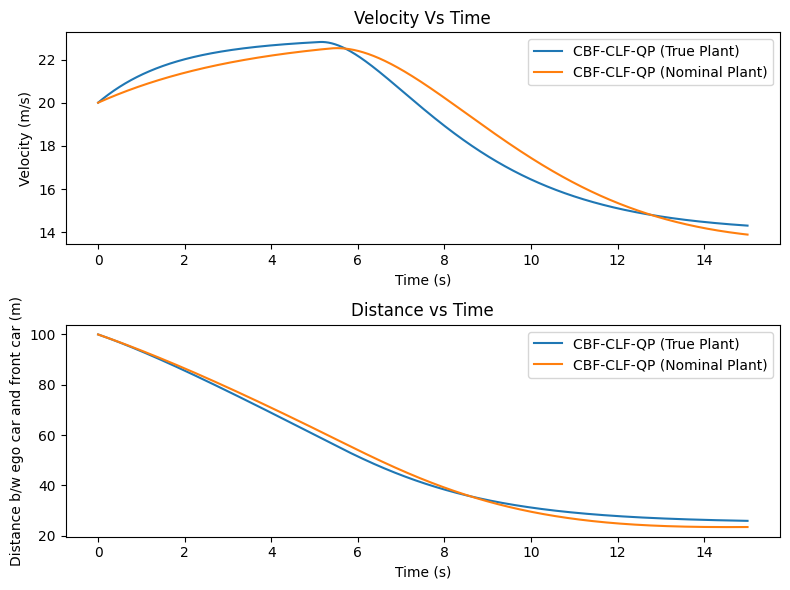

In [148]:
t = np.linspace(0, 15, 10000)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Plot for X_state[0]
ax1.plot(t, X_state_True[0], label = "CBF-CLF-QP (True Plant)")
ax1.plot(t, X_state_Nom[0], label = "CBF-CLF-QP (Nominal Plant)")
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Velocity (m/s)')
ax1.set_title('Velocity Vs Time')
ax1.legend()

# Plot for X_state[1]
ax2.plot(t, X_state_True[1], label = "CBF-CLF-QP (True Plant)")
ax2.plot(t, X_state_Nom[1], label = "CBF-CLF-QP (Nominal Plant)")
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Distance b/w ego car and front car (m)')
ax2.set_title('Distance vs Time')
ax2.legend()
# Adjust spacing between subplots
plt.tight_layout()


# Show the plots
plt.show()
